# Lab work on MNIST classification using multiple machine learning algorithms 

**Objective of the work**.

The purpose of this lab work is to learn multiple machine learning algorithms for classifying handwritten digit images from a MNIST dataset.

**Work Objectives**.

* Study the MNIST dataset and its structure
* Study and implement **some** machine learning algorithms for MNIST classification
* Train models on the MNIST dataset
* Evaluate the performance of the models and compare the results
* Suggest improvements and optimizations for the models

**MNIST dataset**.

The MNIST dataset is a standard dataset for pattern recognition tasks. It consists of 70,000 handwritten digit images from 0 to 9, each image is 28x28 pixels.

## Import libraries

To work with data and models, we need the following libraries:

* numpy
* pandas
* matplotlib
* scikit-learn

In [1]:
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf
for device in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, False)

import sys
import os
import gc

%matplotlib inline
gc.collect()

physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(f'Running on Python {sys.version}, Tensorflow {tf.__version__}.')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(details)

tf.debugging.set_log_device_placement(False)

2023-04-24 16:42:56.600125: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-24 16:42:56.964039: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 16:42:57.589379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Running on Python 3.8.10 (default, Mar 13 2023, 10:26:41) 
[GCC 9.4.0], Tensorflow 2.12.0.
Num GPUs Available:  1
{'compute_capability': (8, 6), 'device_name': 'NVIDIA GeForce RTX 3080 Laptop GPU'}


2023-04-24 16:42:58.464274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-24 16:42:58.613552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-24 16:42:58.613778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Load dataset

In [2]:
num_workers = 0
batch_size = 1000
valid_size = 0.2

MODEL_NAME = "models/SimpleNet"
DATASET_NAME = "byclass"

train_data_path = f'../../input/emnist/emnist-{DATASET_NAME}-train.csv'
test_data_path = f'../../input/emnist/emnist-{DATASET_NAME}-test.csv'
mapping_data_path = f'../../input/emnist/emnist-{DATASET_NAME}-mapping.txt'

with open(mapping_data_path, 'r') as f:
    lines = f.readlines()

class_mapping = {}

for line in lines:
    parts = line.strip().split(' ')
    class_mapping[int(parts[0])] = chr(int(parts[1]))
print(class_mapping)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j', 46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't', 56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z'}


In [3]:
mnist_train = pd.read_csv(train_data_path, header=None, engine="pyarrow")
mnist_test = pd.read_csv(test_data_path, header=None, engine="pyarrow")
mnist_dataset = pd.concat([mnist_train, mnist_test])
print(f"Dataset shape before: {mnist_dataset.shape}")
print(f"Dataset classes before: {''.join(str(class_mapping[key]) for key in sorted(mnist_dataset[0].unique()) if isinstance(class_mapping[key], str))}")

Dataset shape before: (814255, 785)
Dataset classes before: 0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [4]:
mnist_dataset = mnist_dataset.drop(mnist_dataset[9 >= mnist_dataset[0]].index)
mnist_dataset = mnist_dataset.drop(mnist_dataset[36 <= mnist_dataset[0]].index)
mnist_dataset[0] = mnist_dataset[0] - 10
class_mapping = {k - 10: v for k, v in class_mapping.items() if k > 9 and k < 26 + 10}

print(f"Dataset now before: {mnist_dataset.shape}")
print(f"Dataset now before: {''.join(str(class_mapping[key]) for key in sorted(mnist_dataset[0].unique()) if isinstance(class_mapping[key], str))}")
print(class_mapping)

Dataset now before: (174493, 785)
Dataset now before: ABCDEFGHIJKLMNOPQRSTUVWXYZ
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


In [5]:
num_classes = len(mnist_dataset[0].unique())
print(f"Total amount of classes: {num_classes}")

data_rows = len(mnist_dataset)
print(f"Total amount of data rows: {data_rows}")

image_size = int(np.sqrt(len(mnist_dataset.iloc[0][1:])))
print(f"Input image size: {image_size}x{image_size}")

# Images need to be transposed. This line also does the reshaping needed.
images = np.transpose(mnist_dataset.values[:,1:].reshape(data_rows, image_size, image_size, 1), axes=[0,2,1,3]) / 255.0 # img_size * img_size arrays
labels = keras.utils.to_categorical(mnist_dataset.values[:,0], num_classes) # one-hot encoding vectors

print(images.shape)
print(labels.shape)

Total amount of classes: 26
Total amount of data rows: 174493
Input image size: 28x28
(174493, 28, 28, 1)
(174493, 26)


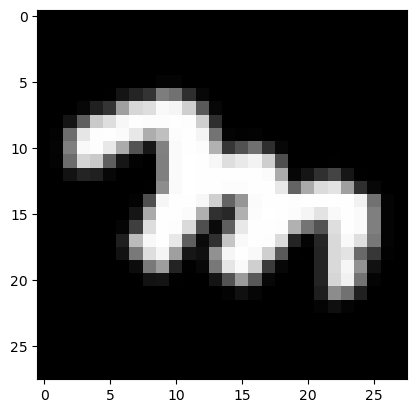

In [6]:
plt.imshow(images[np.random.randint(len(images)),:,:,0], cmap=plt.cm.binary_r, vmin=0, vmax=1)

In [7]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu',
                              input_shape=(image_size,image_size,1)))
model.add(keras.layers.Dropout(.5))

model.add(keras.layers.Conv2D(filters=128, kernel_size=(15,15), strides=3, activation='relu', 
                              input_shape=(image_size,image_size,1)))
model.add(keras.layers.Dropout(.5))

model.add(keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=2, activation='relu', 
                              input_shape=(image_size,image_size,1)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=num_classes * 8, activation='relu'))
model.add(keras.layers.Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

MCP = keras.callbacks.ModelCheckpoint('Best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=3,mode='max')
RLP = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        160       
                                                                 
 dropout (Dropout)           (None, 27, 27, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 128)         921728    
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 128)         409728    
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 208)               2

2023-04-24 16:43:06.055123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-24 16:43:06.055254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-24 16:43:06.055466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(images,labels,test_size=0.2, random_state = 42)
train_x,val_x,train_y,val_y = train_test_split(train_x,train_y,test_size=0.2, random_state = 42)

In [9]:
history = model.fit(train_x,train_y,epochs=1000,batch_size=1000,validation_data=(val_x,val_y),callbacks=[MCP,ES,RLP])

Epoch 1/1000


2023-04-24 16:43:09.134525: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-24 16:43:10.371267: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-24 16:43:11.553611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-24 16:43:11.575189: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f85cc008b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-24 16:43:11.575206: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2023-04-24 16:43:11.595540: I tensorflow/compiler/mlir/tensorflow/utils/du

112/112 [==============================] - ETA: 0s - loss: 1.1299 - accuracy: 0.6831
Epoch 1: val_accuracy improved from -inf to 0.89344, saving model to Best_points.h5
112/112 [==============================] - 9s 40ms/step - loss: 1.1299 - accuracy: 0.6831 - val_loss: 0.3812 - val_accuracy: 0.8934 - lr: 0.0010
Epoch 2/1000
110/112 [============================>.] - ETA: 0s - loss: 0.3291 - accuracy: 0.9028
Epoch 2: val_accuracy improved from 0.89344 to 0.94434, saving model to Best_points.h5
112/112 [==============================] - 3s 30ms/step - loss: 0.3274 - accuracy: 0.9034 - val_loss: 0.1913 - val_accuracy: 0.9443 - lr: 0.0010
Epoch 3/1000
111/112 [============================>.] - ETA: 0s - loss: 0.2244 - accuracy: 0.9344
Epoch 3: val_accuracy improved from 0.94434 to 0.95079, saving model to Best_points.h5
112/112 [==============================] - 3s 31ms/step - loss: 0.2244 - accuracy: 0.9344 - val_loss: 0.1687 - val_accuracy: 0.9508 - lr: 0.0010
Epoch 4/1000
111/112 [====

112/112 [==============================] - 3s 30ms/step - loss: 0.0413 - accuracy: 0.9869 - val_loss: 0.0706 - val_accuracy: 0.9827 - lr: 2.0000e-04
Epoch 27/1000
111/112 [============================>.] - ETA: 0s - loss: 0.0388 - accuracy: 0.9874
Epoch 27: val_accuracy did not improve from 0.98270
112/112 [==============================] - 3s 29ms/step - loss: 0.0388 - accuracy: 0.9874 - val_loss: 0.0704 - val_accuracy: 0.9825 - lr: 2.0000e-04
Epoch 28/1000
111/112 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9878
Epoch 28: val_accuracy improved from 0.98270 to 0.98277, saving model to Best_points.h5
112/112 [==============================] - 3s 30ms/step - loss: 0.0385 - accuracy: 0.9877 - val_loss: 0.0705 - val_accuracy: 0.9828 - lr: 1.0000e-04
Epoch 29/1000
111/112 [============================>.] - ETA: 0s - loss: 0.0364 - accuracy: 0.9882
Epoch 29: val_accuracy improved from 0.98277 to 0.98281, saving model to Best_points.h5
112/112 [===================

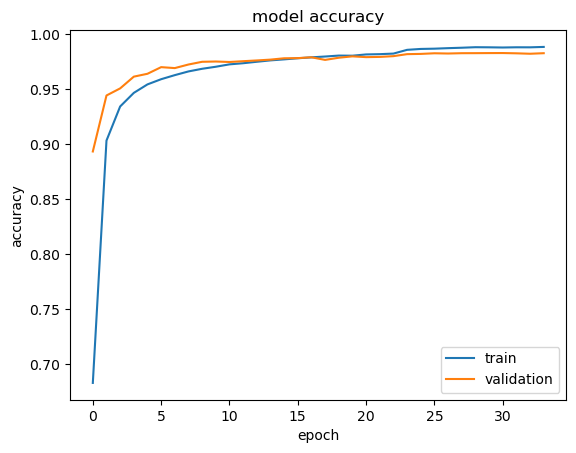

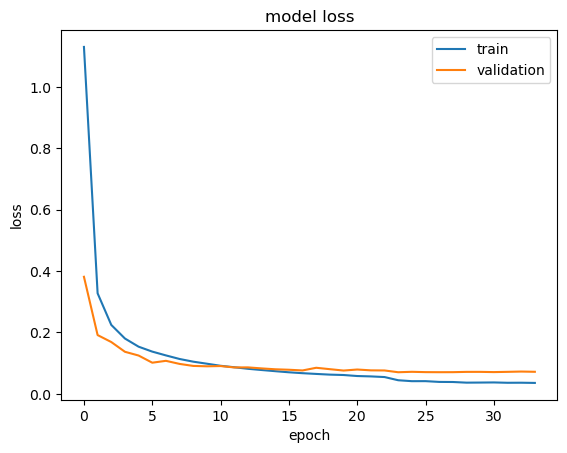

In [10]:
# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [11]:
test_history = model.evaluate(test_x,test_y)
test_history

1091/1091 [==============================] - 8s 7ms/step - loss: 0.0857 - accuracy: 0.9796


[0.08571263402700424, 0.9796268939971924]

(1, 28, 28, 1)
1/1 [==============================] - 0s 10ms/step
D 0.99948066
[[0.    0.    0.    0.999 0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   ]]


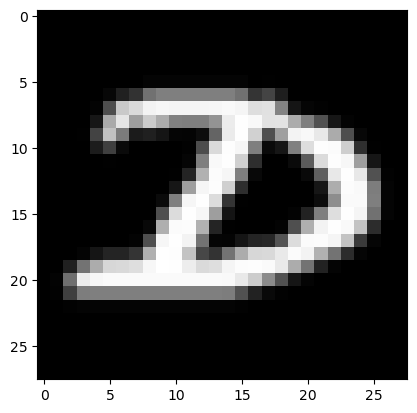

In [40]:
idx = np.random.randint(len(test_x))
image = test_x[idx:idx+1,:,:,:]
print(image.shape)

plt.imshow(image[0,:,:,0], cmap=plt.cm.binary_r, vmin=0, vmax=1)
res = model.predict(image)

res_idx = np.argmax(res)
print(class_mapping[res_idx], np.max(res))
print(np.round(res * 1000) / 1000)

In [79]:
import cv2
import matplotlib.pyplot as plt

def grab_frame(cap):
    ret,frame = cap.read()
    return cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

#Initiate the two cameras
cap1 = cv2.VideoCapture(0)

#create two subplots
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

#create two image plots
im1 = ax1.imshow(grab_frame(cap1))
im2 = ax2.imshow(grab_frame(cap2))

plt.ion()

while True:
    im1.set_data(grab_frame(cap1))
    im2.set_data(grab_frame(cap2))
    plt.pause(0.2)

plt.ioff() # due to infinite loop, this gets never called.
plt.show()

ImportError: libopencv_hdf.so.406: cannot open shared object file: No such file or directory